In [14]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import json
import cv2
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

# Load the postprocess_redgreen_human_data.py file
from postprocess_redgreen_human_data import *

##############################################################
# DEAR EXPERIMENTER, DEFINE ALL VARIABLES BELOW IN THIS CELL #
##############################################################

###################################################################################
expected_num_participants = 59 # expected number of participants
participant_FPS = 30 # frames per second given to participants
dataset_name = 'cogsci_2025_trials_reduced'
db_name = 'cogsci_2025_trials_reduced_ecog_v0_redgreen.db'
# NOTE: Determine project root - try multiple possible locations
current_dir = os.getcwd()
# If we're in the backend directory, go up one level
if os.path.basename(current_dir) == 'backend':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

# NOTE: this is the db file name - try root instance/ first, then backend/instance/
db_path = os.path.join(project_root, "instance", db_name)  


# db_path = os.path.join(os.getcwd(), "cogsci_2025_human_raw_database.db")
# NOTE: this is the path to the trial data
path_to_data = os.path.join(project_root, "backend", "trial_data", dataset_name)
print(f"Using database: {db_path}")
print(f"Using trial data path: {path_to_data}")
#################################################################################

Using database: /Users/arijitdasgupta/Desktop/projects/red_green_projects/red_green_experimental_site/instance/cogsci_2025_trials_reduced_ecog_v0_redgreen.db
Using trial data path: /Users/arijitdasgupta/Desktop/projects/red_green_projects/red_green_experimental_site/backend/trial_data/cogsci_2025_trials_reduced


## Extract, preprocess and save data into pkl file

In [10]:
session_df, trial_df, keystate_df, rgplot_df, valid_trial_ids, global_trial_names = extract_human_data(db_path, path_to_data)
keystate_by_trial = save_human_data_by_trial(trial_df, keystate_df, path_to_data)

Saved human data as CSV files in /Users/arijitdasgupta/Desktop/projects/red_green_projects/red_green_experimental_site/backend/trial_data/cogsci_2025_trials_reduced


## Check duplicates, print demographic info and see score distribution per participant

In [11]:
###########################################################################################
# Unit test to ensure no duplicated trials and all trials have the appropriate data count #
##########################################################################################
duplicates = find_duplicate_completed_trials(trial_df)
if not duplicates.empty:
    print("Duplicate completed trials found:")
    print(duplicates)
else:
    print("No duplicate completed trials found.")
trial_counts = count_completed_trials_by_global_name(trial_df)
trial_counts[trial_counts['count'] != expected_num_participants//2]

No duplicate completed trials found.


,global_trial_name,count
0,E1,1
1,E2,1
2,E3,1


In [12]:
####################
# Demographic Data #
####################
# NOTE: REWRITE THE PATH TO THE DEMOGRAPHIC DATA TO FIT YOUR DATA
demographic_path = os.path.join(os.getcwd(), "cogsci_2025_human_demographics.csv")
print_demo_data(session_df, demographic_path)

AssertionError: Mismatch in session and demographic data.

1


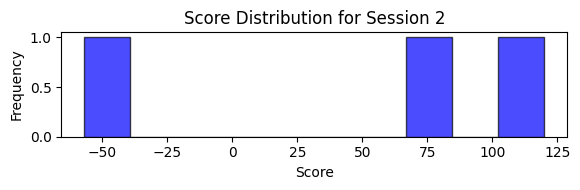

In [13]:
#######################################################################
# Distribution of scores identified in CURRENT valid participant data #
#######################################################################
plot_scores_distribution(trial_df)